In [1]:
#NLP project - IMDB - topic modeling
#https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
#https://github.com/RaRe-Technologies
#https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
#https://github.com/lda-project/lda
#https://github.com/derekgreene/dynamic-nmf
#https://nlpforhackers.io/topic-modeling/
#https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
#https://docs.python.org/2/library/re.html
#https://pythonspot.com/nltk-stop-words/
#https://jakevdp.github.io/WhirlwindTourOfPython/14-strings-and-regular-expressions.html
#https://textblob.readthedocs.io/en/dev/advanced_usage.html
#https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/
#https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
#https://rare-technologies.com/tutorial-on-mallet-in-python/

In [1]:
import nltk
import gensim
import logging
import os
import re
import gensim
import spacy
import pyLDAvis
import en_core_web_sm
import warnings

import numpy as np
import pandas as pd
import gensim.corpora as corpora
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
import pyLDAvis.gensim  # don't skip this

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from spacy.lang.en import English
from nltk.corpus import stopwords

from pprint import pprint
from spacy.lang.en import English

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
df_review=pd.read_excel("../CannaConnect/Dataset/description_clean.xlsx")
df_review=df_review.iloc[:,1]
df_review.head()

0     og   hybrid pack strong punch name supposedly...
1     aloha white widow especially potent cut white...
2     sativa hybrid bred spain medical seed co bree...
3     dawgs hybrid g chemdawg genetics bred canadia...
4    kosher tangie k gold  indica hybrid combine le...
Name: Description, dtype: object

In [4]:
# Convert to list
data = df_review.values.tolist()

In [5]:
stop_words = stopwords.words('english')

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])

[['og', 'hybrid', 'pack', 'strong', 'punch', 'name', 'supposedly', 'refers', 'strength', 'high', 'price', 'first', 'started', 'showing', 'hollywood', 'plant', 'og', 'tends', 'produce', 'large', 'dark', 'green', 'bud', 'stem', 'user', 'report', 'strong', 'body', 'indica', 'pain', 'relief', 'alert', 'cerebral', 'feeling', 'thanks', 'sativa', 'side']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['og', 'hybrid', 'pack', 'strong', 'punch', 'name', 'supposedly', 'refers', 'strength', 'high', 'price', 'first', 'started', 'showing', 'hollywood', 'plant', 'og', 'tends', 'produce', 'large', 'dark', 'green', 'bud', 'stem', 'user_report', 'strong', 'body', 'indica', 'pain', 'relief', 'alert', 'cerebral', 'feeling', 'thanks', 'sativa', 'side']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = en_core_web_sm.load()

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['hybrid', 'pack', 'strong', 'punch', 'name', 'supposedly', 'refer', 'strength', 'high', 'price', 'first', 'start', 'show', 'hollywood', 'plant', 'tend', 'produce', 'large', 'dark', 'green', 'bud', 'stem', 'user_report', 'strong', 'body', 'indica', 'pain', 'relief', 'alert', 'cerebral', 'feel', 'thank', 'sativa', 'side']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1)]]


In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('alert', 1),
  ('body', 1),
  ('bud', 1),
  ('cerebral', 1),
  ('dark', 1),
  ('feel', 1),
  ('first', 1),
  ('green', 1),
  ('high', 1),
  ('hollywood', 1),
  ('hybrid', 1),
  ('indica', 1),
  ('large', 1),
  ('name', 1),
  ('pack', 1),
  ('pain', 1),
  ('plant', 1),
  ('price', 1),
  ('produce', 1),
  ('punch', 1),
  ('refer', 1),
  ('relief', 1),
  ('sativa', 1),
  ('show', 1),
  ('side', 1),
  ('start', 1),
  ('stem', 1),
  ('strength', 1),
  ('strong', 2),
  ('supposedly', 1),
  ('tend', 1),
  ('thank', 1),
  ('user_report', 1)]]

In [25]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [27]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"haze" + 0.024*"seed" + 0.012*"sativa" + 0.010*"create" + '
  '0.009*"strawberry" + 0.009*"offer" + 0.008*"enjoy" + 0.008*"cheese" + '
  '0.007*"genetic" + 0.007*"physical"'),
 (1,
  '0.021*"hybrid" + 0.018*"aroma" + 0.017*"indica" + 0.016*"kush" + '
  '0.015*"sweet" + 0.013*"body" + 0.013*"sativa" + 0.012*"white" + '
  '0.012*"sour" + 0.010*"purple"'),
 (2,
  '0.024*"high" + 0.021*"flower" + 0.019*"indica" + 0.013*"cannabis" + '
  '0.012*"time" + 0.012*"plant" + 0.010*"grow" + 0.010*"week" + 0.010*"cbd" + '
  '0.009*"cup"')]


In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.44078132658813

Coherence Score:  0.3707594431010921


In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=32, step=2)

In [33]:
#model_list.to_excel("../nlp/model_list.xlsx")
#coherence_values.to_excel("../nlp/coherence_values.xlsx")

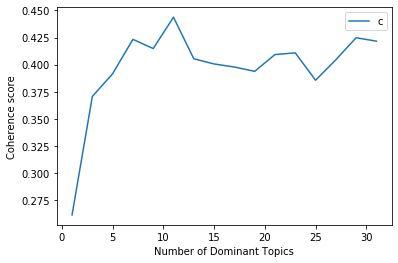

In [18]:
# Show graph
limit=32; start=1; step=2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Dominant Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.2616
Num Topics = 3  has Coherence Value of 0.3708
Num Topics = 5  has Coherence Value of 0.3917
Num Topics = 7  has Coherence Value of 0.4234
Num Topics = 9  has Coherence Value of 0.4149
Num Topics = 11  has Coherence Value of 0.4438
Num Topics = 13  has Coherence Value of 0.4055
Num Topics = 15  has Coherence Value of 0.4007
Num Topics = 17  has Coherence Value of 0.3979
Num Topics = 19  has Coherence Value of 0.3939
Num Topics = 21  has Coherence Value of 0.4094
Num Topics = 23  has Coherence Value of 0.411
Num Topics = 25  has Coherence Value of 0.3858
Num Topics = 27  has Coherence Value of 0.4046
Num Topics = 29  has Coherence Value of 0.4249
Num Topics = 31  has Coherence Value of 0.4218


In [24]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.037*"physical" + 0.031*"enjoy" + 0.031*"consumer" + 0.025*"white_widow" + '
  '0.019*"offer" + 0.016*"terpene_profile" + 0.016*"cut" + 0.016*"ideal" + '
  '0.015*"express" + 0.015*"earth"'),
 (1,
  '0.060*"orange" + 0.039*"trainwreck" + 0.025*"influence" + 0.021*"sfv" + '
  '0.020*"settle" + 0.017*"family" + 0.015*"night" + 0.014*"valley" + '
  '0.014*"comfortable" + 0.014*"couch"'),
 (2,
  '0.144*"cbd" + 0.037*"thc" + 0.031*"ratio" + 0.026*"psychoactive" + '
  '0.024*"call" + 0.018*"content" + 0.016*"mental_clarity" + 0.015*"swiss" + '
  '0.015*"american" + 0.013*"reduce"'),
 (3,
  '0.046*"terpene" + 0.046*"hawaiian" + 0.045*"mango" + 0.031*"romulan" + '
  '0.028*"overall" + 0.027*"bank" + 0.025*"caution" + 0.020*"cream" + '
  '0.016*"drive" + 0.015*"legend"'),
 (4,
  '0.078*"cup" + 0.048*"cooky" + 0.045*"cheese" + 0.024*"girl_scout" + '
  '0.023*"place" + 0.018*"cultivate" + 0.015*"pair" + 0.014*"outdoors" + '
  '0.014*"platinum" + 0.013*"heavily"'),
 (5,
  '0.064*"thai" + 